**Importing necessary libraries for data visualization and manipulation :**

In [1]:
# Used for creating static, interactive, and animated visualizations in Python
import matplotlib.pyplot as plt

# Used for creating line markers within plots
from matplotlib.lines import Line2D

# Provides a way of using operating system dependent functionality like reading or writing to a file system
import os

# Implements binary protocols for serializing and de-serializing a Python object structure.
import pickle

# Data manipulation and analysis library
import pandas as pd

# Fundamental package for scientific computing with Python
import numpy as np

# Represents a duration, the difference between two dates or times.
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

**Importing the PPG Data**

In [2]:
# Set directory path where the .pkl files are stored
extracted_folder = 'C:/Users/adior/Documents/Digital Medical Tech - degree/Final Mop Project/Train Files'
#extracted_folder = 'C:/Users/Idan Lichter/OneDrive/Desktop/study/3rd year/Final Project/Train Files'

# Initializes an empty list that will later store the .pkl data as pandas DataFrames
ppg_dataframes = []

#Initializes an empty dictionary that will map patient IDs to their corresponding index in ppg_dataframes
ID2Index = {}

# extract_patient_id extracts patient_id from file_name
# It splits the filename by (_), takes the last part, then splits it by (.) , returns the first element of the result
def extract_patient_id(file_name):
    return file_name.split('_')[-1].split('.')[0]

# List of all .pkl files in the directory
pkl_files = [f for f in os.listdir(extracted_folder) if f.endswith('.pkl')]

# Loop through the .pkl files and load each as a DataFrame, storing them with the patient's ID as a column
# 'enumerate' is used here to get both the index (i) and the filename (file_name) in each iteration
for i, file_name in enumerate(pkl_files):

    # Process only PPG files
    if "PPG" in file_name:

        # Calls the previously defined extract_patient_id function to get the patient_id from the filename
        patient_id = extract_patient_id(file_name)
        file_path = os.path.join(extracted_folder, file_name)

        with open(file_path, 'rb') as file:
            # Load Data
            data = pickle.load(file)
            # Inserts new column at the first position of DataFrame with a label "ID" filled with the patient_id
            data.insert(0,"ID",patient_id)
            ppg_dataframes.append(data)
            # Map Patient_id to Index by updating the ID2Index dict, setting the current patient_id as a key whose value
            #  is the current index of the DataFrame in ppg_dataframes.
            ID2Index[patient_id] = len(ppg_dataframes) - 1

Self check of ppg_dataframes :

In [4]:
# Display the first 10 rows of the 5th DataFrame in the list to inspect the initial few records and ensure data was loaded correctly
ppg_dataframes[4].head(10)

,ID,DataTime,TIMESTAMP_MS,COUNTER,PULSE_BPM,SPO2_PCT,SPO2_STATUS,PLETH,BATTERY_PCT,RED_ADC,IR_ADC,PERFUSION_INDEX
0,24955278,2021-06-29 09:09:48.335,0,9.0,74.0,95.6,0.0,19543.0,69.6,181968.0,173986.0,1.2
1,24955278,2021-06-29 09:09:48.345,10,10.0,74.0,95.6,0.0,17768.0,69.6,181965.0,173995.0,1.2
2,24955278,2021-06-29 09:09:48.355,20,11.0,74.0,95.6,0.0,15944.0,69.6,182028.0,174027.0,1.2
3,24955278,2021-06-29 09:09:48.365,30,12.0,74.0,95.6,0.0,14214.0,69.6,182075.0,173851.0,1.2
4,24955278,2021-06-29 09:09:48.375,40,13.0,74.0,95.6,0.0,12532.0,69.6,182089.0,174101.0,1.2
5,24955278,2021-06-29 09:09:48.385,50,14.0,74.0,95.6,0.0,11041.0,69.6,182133.0,174365.0,1.2
6,24955278,2021-06-29 09:09:48.395,60,15.0,74.0,95.6,0.0,9693.0,69.6,182192.0,174152.0,1.2
7,24955278,2021-06-29 09:09:48.405,70,16.0,74.0,95.6,0.0,8538.0,69.6,182067.0,174217.0,1.2
8,24955278,2021-06-29 09:09:48.415,80,17.0,74.0,95.6,0.0,7574.0,69.6,182214.0,174245.0,1.2
9,24955278,2021-06-29 09:09:48.425,90,18.0,74.0,95.6,0.0,6803.0,69.6,182300.0,174233.0,1.2


**Plotting a Time stamp recording with resets in time stamp - an issue we want to solve so we will get continuous segments :**

Text(0, 0.5, 'Index')

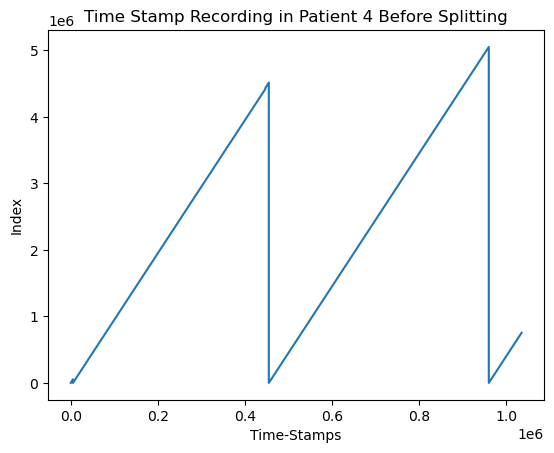

In [ ]:
# Plot the 'TIMESTAMP_MS' column for the 5th DataFrame in the list to visualize the timestamp sequence
plt.plot(ppg_dataframes[4]['TIMESTAMP_MS'])

# Set the title of the plot to indicate that this is the timestamp recording for Patient 4 before any data splitting has occurred.
plt.title('Time Stamp Recording in Patient 4 Before Splitting')

# Label the x-axis as 'Time-Stamps' to clarify what is being represented along the horizontal axis
plt.xlabel('Time-Stamps')

# Label the y-axis as 'Index' to indicate that the vertical axis corresponds to the row index in the DataFrame
plt.ylabel('Index')

**Split PPG signals into continuous segments when restarted**

In [5]:
def split_dataframe_when_restarted(dataframe):
    """
    Split a DataFrame into multiple smaller DataFrames whenever there is a restart in the timestamp sequence.

    Parameters:
        dataframe : The input DataFrame containing a 'TIMESTAMP_MS' column.

    Returns:
        list: A list of DataFrames, each representing a continuous segment of data.
    """

    # Calculate the difference between consecutive timestamps
    diffs = dataframe['TIMESTAMP_MS'].diff().fillna(0)

    # Identify restarts where the difference is negative
    restarts = (diffs < 0).astype(int)

    # Create a grouping column by taking the cumulative sum of restarts
    groups = restarts.cumsum()

    # Split the dataframe using the grouping column and reset the index
    split_dfs = [group.reset_index(drop=True) for _, group in dataframe.groupby(groups)]

    return split_dfs

# Contain all continuous segments in data
split_ppg_dataframes = []

for df in ppg_dataframes:
    # Iterate through each DataFrame in the ppg_dataframes list
    split_dfs = split_dataframe_when_restarted(df)
    # Add the resulting smaller DataFrames to the split_ppg_dataframes list
    split_ppg_dataframes.extend(split_dfs)

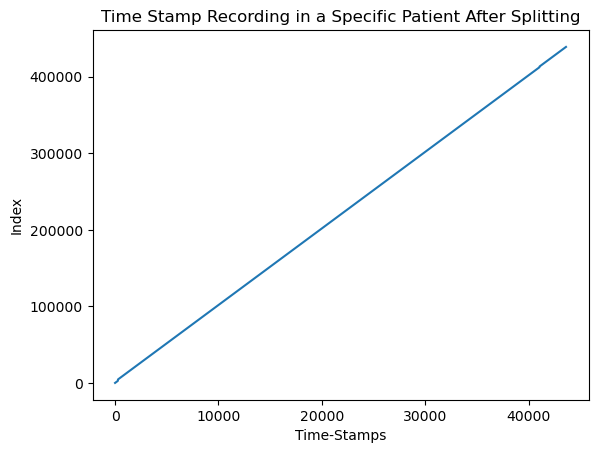

In [6]:
# Plot the 'TIMESTAMP_MS' column for the 5th DataFrame in the split_ppg_dataframes list
plt.plot(split_ppg_dataframes[4]['TIMESTAMP_MS'])

# Set the title of the plot to indicate that this is the timestamp recording for a specific patient after the data has been split
plt.title('Time Stamp Recording in a Specific Patient After Splitting')

# Label the x-axis as 'Time-Stamps' to clarify what is being represented along the horizontal axis
plt.xlabel('Time-Stamps')

# Label the y-axis as 'Index' to indicate that the vertical axis corresponds to the row index in the DataFrame
plt.ylabel('Index')

# Display the plot.
plt.show()

**Next step is to perform analysis of PLETH distribution values across all patients because it provides essential insights into the characteristics and variability of the PPG signals collected :**

In [7]:
# extracts the 'PLETH' column from each DataFrame in the list ppg_dataframes
# 'PLETH' columns (which are pandas Series) are concatenated into a single pandas Series using pd.concat()
all_pleth_values = pd.concat([df['PLETH'] for df in ppg_dataframes])
all_pleth_values.value_counts()

PLETH
0.0        8286288
62258.0     985738
3276.0      451641
32767.0      32853
65535.0      29856
            ...   
64705.0          1
62794.0          1
2489.0           1
1865.0           1
63327.0          1
Name: count, Length: 63151, dtype: int64

In [8]:
# Display all_pleth_values besides the value of zero
all_pleth_values_filtered = all_pleth_values[all_pleth_values!=0]

In [9]:
# Function to plot the distribution of PLETH values from a dataset
# This function visualizes the data by the frequency of each unique PLETH value
def plot_pleth_values(all_pleth_values, title, color):

   # Calculate the frequency of each unique PLETH value and sort them by the value (index)
   length_counts = all_pleth_values.value_counts().sort_index()

   # Create the plot with a specified figure size
   plt.figure(figsize=(20, 4))
   # Plot the frequency counts as a bar chart with the specified color
   length_counts.plot(kind='bar', color=color, alpha=0.7, edgecolor='black')
   # Set the title of the plot
   plt.title(title)
   # Label the x-axis as 'PLETH Values'
   plt.xlabel('PLETH Values')
   # Label the y-axis as 'Frequency'
   plt.ylabel('Frequency')
   # Add a grid to the y-axis for better readability
   plt.grid(axis='y')
   # Rotate x-axis labels by 90 degrees for better visibility
   plt.xticks(rotation=90)
   # Display the plot
   plt.show()

# Function to plot the distribution of PLETH values as a percentage of the total count
# This function visualizes the data by normalizing the frequencies to percentages
def plot_pleth_values_norm(all_pleth_values_norm, title, color):
   # Get counts of each unique PLETH value
   length_counts = all_pleth_values.value_counts()
   # Normalize the counts to get percentages
   length_percentages = (length_counts / length_counts.sum()) * 100  # Convert to percentage

   # Create the plot with a specified figure size
   plt.figure(figsize=(20, 4))
   # Plot the percentages as a bar chart with the specified color
   length_percentages.sort_index().plot(kind='bar', color=color, alpha=0.7, edgecolor='black')
   # Set the title of the plot
   plt.title(title)
   # Label the x-axis as 'PLETH Values'
   plt.xlabel('PLETH Values')
   # Label the y-axis as 'Percentage (%)'
   plt.ylabel('Percentage (%)')
   # Add a grid to the y-axis for better readability
   plt.grid(axis='y')
   # Rotate x-axis labels by 90 degrees for better visibility if needed
   plt.xticks(rotation=90)
   # Display the plot
   plt.show()

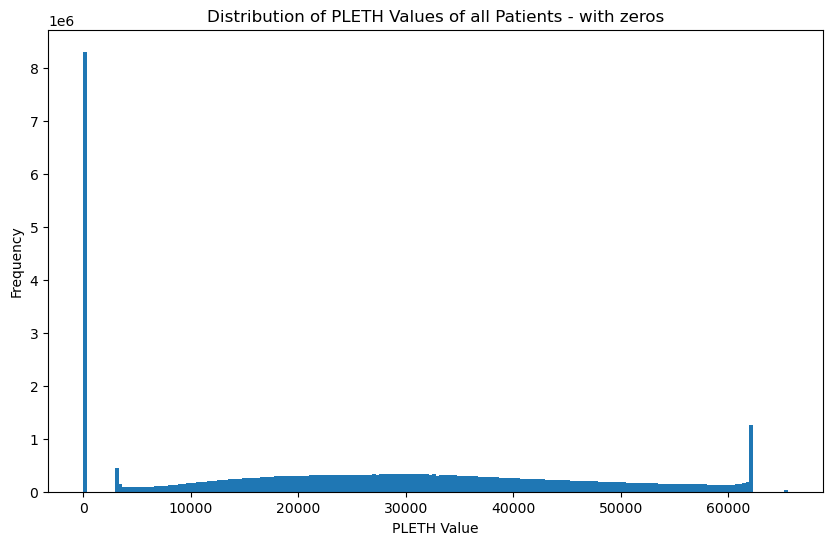

In [10]:
# Plotting the histogram of all PLETH values, including zeros
plt.figure(figsize=(10, 6))
plt.hist(all_pleth_values, bins=200)

# Set the title of the plot to indicate that it shows the distribution of PLETH values across all patients, including zeros
plt.title('Distribution of PLETH Values of all Patients - with zeros')

# Label the x-axis as 'PLETH Value' to indicate what is represented along the horizontal axis
plt.xlabel('PLETH Value')

# Label the y-axis as 'Frequency' to indicate that the vertical axis represents the frequency of each PLETH value
plt.ylabel('Frequency')

# Display the plot
plt.show()

**There was a significant peak at the value zero, which indicates an abnormal measurement, likely due to sensor errors or external interference, which can skew the analysis**

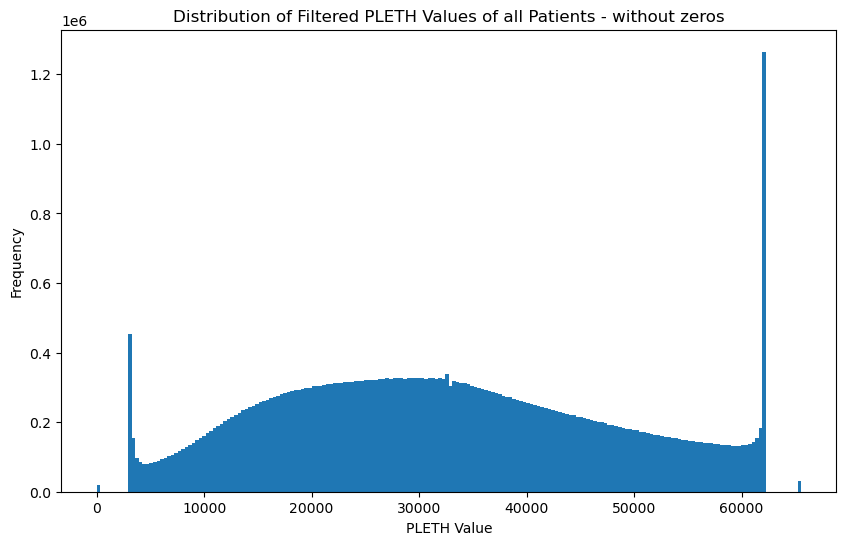

In [11]:
# Plotting the histogram of all PLETH values, excluding zeros
plt.figure(figsize=(10, 6))
plt.hist(all_pleth_values_filtered, bins=200)

# Set the title of the plot to indicate that it shows the distribution of filtered PLETH values across all patients, excluding zeros
plt.title('Distribution of Filtered PLETH Values of all Patients - without zeros')

# Label the x-axis as 'PLETH Value' to indicate what is represented along the horizontal axis
plt.xlabel('PLETH Value')

# Label the y-axis as 'Frequency' to indicate that the vertical axis represents the frequency of each PLETH value
plt.ylabel('Frequency')

# Display the plot
plt.show()

**This adjustment provided a more accurate depiction of the data, revealing the true characteristics of the PLETH values without the distortion caused by the abnormal zero measurements.**

In [12]:
# Saturation values that were defined by vizualization analysis
saturation_val_col=[1,3276.0,62258.0,65535.0]
saturation_val_col

[1, 3276.0, 62258.0, 65535.0]

# Damaged areas in segments:

Different kind of plots that display 4 types of damaged areas.

In [13]:
def plot_histogram(sequence_lengths, title, color):
    """
    Plot a histogram of sequence lengths to display the frequency of each unique sequence length.

    Parameters:
        sequence_lengths (list or array-like): A list or array containing the lengths of sequences to be plotted.
        title (str): The title of the histogram.
        color (str): The color of the bars in the histogram.

    Returns:
        None: This function does not return any value. It displays a histogram plot.
    """
    # Create a pandas Series from the input sequence lengths for easier value counting and sorting
    sequence_counts = pd.Series(sequence_lengths)

    # Count the occurrences of each sequence length and sort them by the sequence length
    length_counts = sequence_counts.value_counts().sort_index()

    # Set up the plot with a specified size (20x4 inches)
    plt.figure(figsize=(20, 4))

    # Plot the data as a bar chart with the specified color and aesthetics
    length_counts.plot(kind='bar', color=color, alpha=0.7, edgecolor='black')

    # Set the title of the plot
    plt.title(title)

    # Label the x-axis as 'Sequence Length'
    plt.xlabel('Sequence Length')

    # Label the y-axis as 'Frequency'
    plt.ylabel('Frequency')

    # Add a grid to the y-axis for better readability
    plt.grid(axis='y')

    # Rotate x-axis labels by 90 degrees for better visibility
    plt.xticks(rotation=90)

    # Display the plot
    plt.show()


def plot_norm_histogram(sequence_lengths, title, color):
    """
    Plot a normalized histogram of sequence lengths showing the percentage of each sequence length relative to the total.

    Parameters:
        sequence_lengths (list or array-like): A list or array containing the lengths of sequences to be plotted.
        title (str): The title of the histogram.
        color (str): The color of the bars in the histogram.

    Returns:
        None: This function does not return any value. It displays a normalized histogram plot.
    """
    # Create a pandas Series from the input sequence lengths for easier value counting and sorting
    sequence_counts = pd.Series(sequence_lengths)

    # Count the occurrences of each sequence length
    length_counts = sequence_counts.value_counts()

    # Normalize the counts by converting them to percentages of the total
    length_percentages = (length_counts / length_counts.sum()) * 100

    # Set up the plot with a specified size (20x4 inches)
    plt.figure(figsize=(20, 4))

    # Plot the data as a bar chart with the specified color and aesthetics, displaying percentages
    length_percentages.sort_index().plot(kind='bar', color=color, alpha=0.7, edgecolor='black')

    # Set the title of the plot
    plt.title(title)

    # Label the x-axis as 'Sequence Length'
    plt.xlabel('Sequence Length')

    # Label the y-axis as 'Percentage (%)'
    plt.ylabel('Percentage (%)')

    # Add a grid to the y-axis for better readability
    plt.grid(axis='y')

    # Rotate x-axis labels by 90 degrees for better visibility if needed
    plt.xticks(rotation=90)

    # Display the plot
    plt.show()


def plot_cumulative_histogram(sequence_lengths, title, color):
    """
    Plot a cumulative graph for saturation areas based on provided sequence lengths.

    Parameters:
        sequence_lengths (list or array-like): A list or array containing the lengths of saturation sequences.
        title (str): The title of the cumulative graph.
        color (str): The color of the line in the graph.

    Returns:
        None: This function does not return any value. It displays a cumulative graph plot.
    """
    # Create a pandas Series from the input sequence lengths for easier value counting and sorting
    sequence_counts = pd.Series(sequence_lengths)

    # Set up the plot with a specified size (20x4 inches)
    plt.figure(figsize=(20, 4))

    # Plot the data as a cumulative histogram
    plt.hist(sequence_counts, bins=range(int(sequence_counts.min()), int(sequence_counts.max()) + 1),
             color=color, alpha=0.7, edgecolor='black', cumulative=True, density=True)

    # Convert y-axis to percentage format
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y * 100:.0f}%'))

    # Set the title of the plot
    plt.title(title)

    # Label the x-axis as 'Saturation Sequence Length'
    plt.xlabel('Saturation Sequence Length')

    # Label the y-axis as 'Cumulative Percentage (%)'
    plt.ylabel('Cumulative Percentage (%)')

    # Add a grid to the y-axis for better readability
    plt.grid(axis='y')

    # Rotate x-axis labels by 90 degrees for better visibility
    plt.xticks(rotation=90)

    # Display the plot
    plt.show()

**Saturation Areas:[1,3276,62258,65535]**

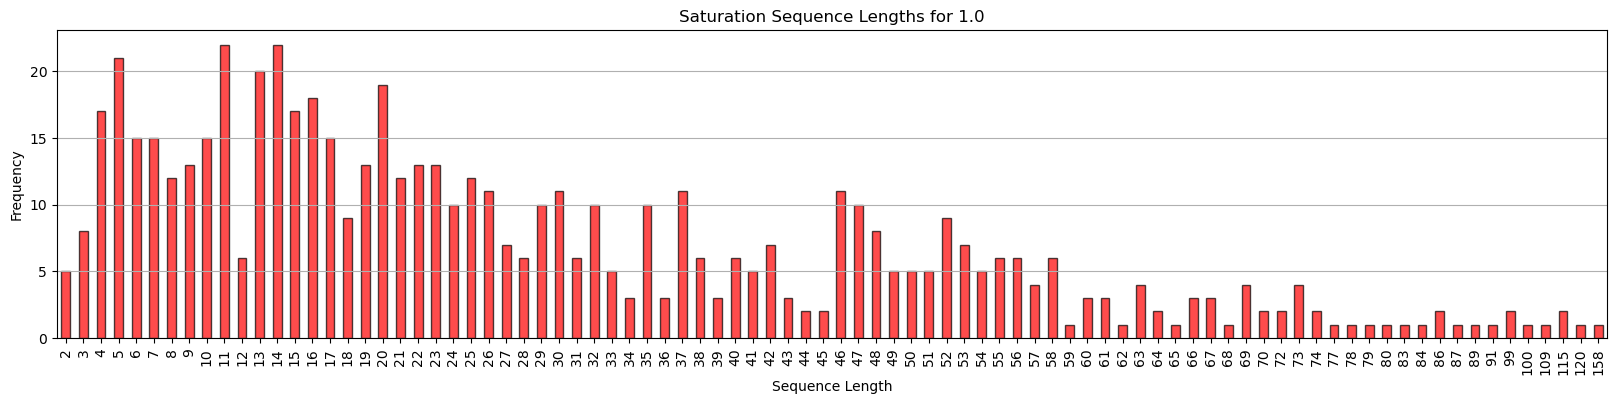

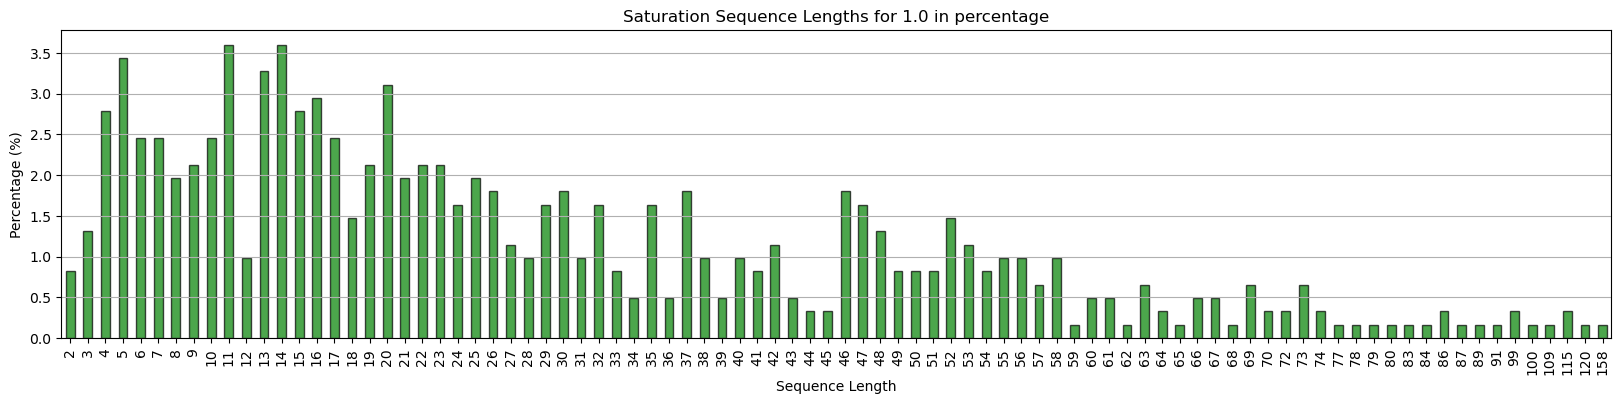

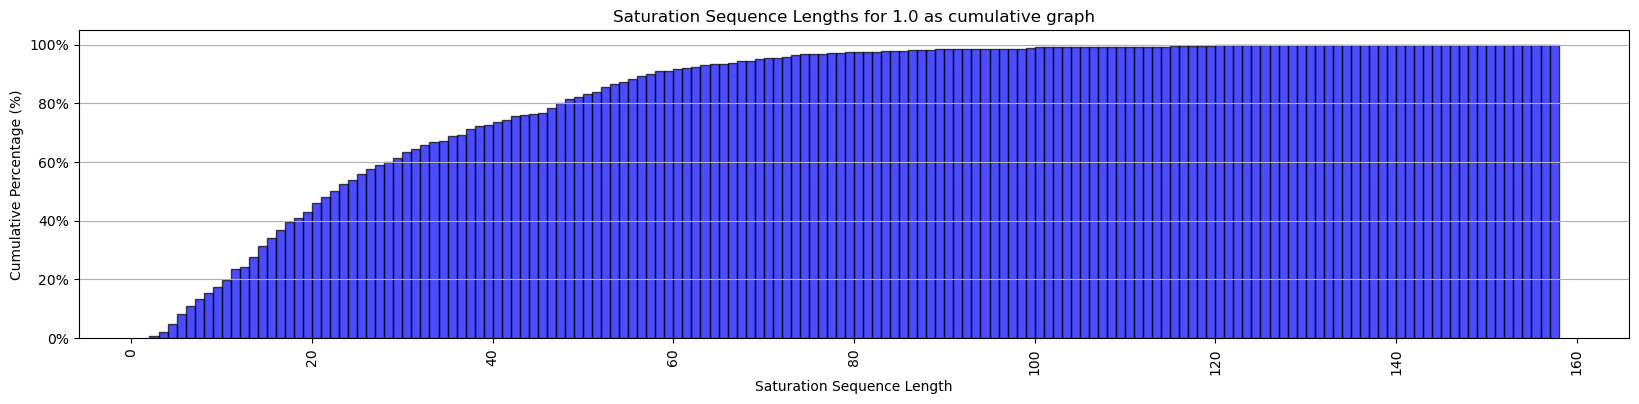

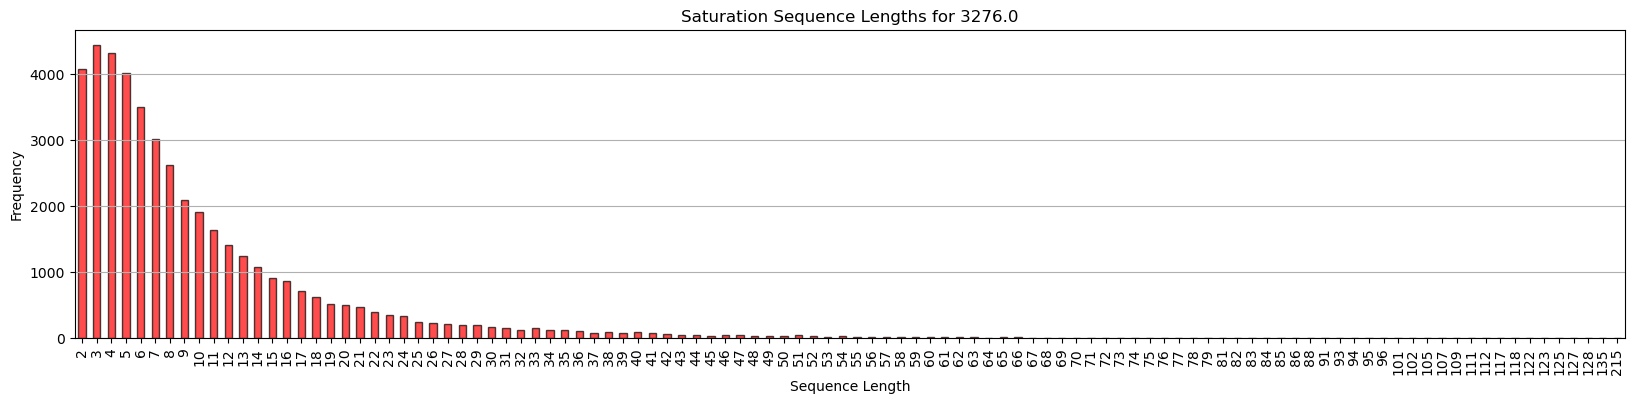

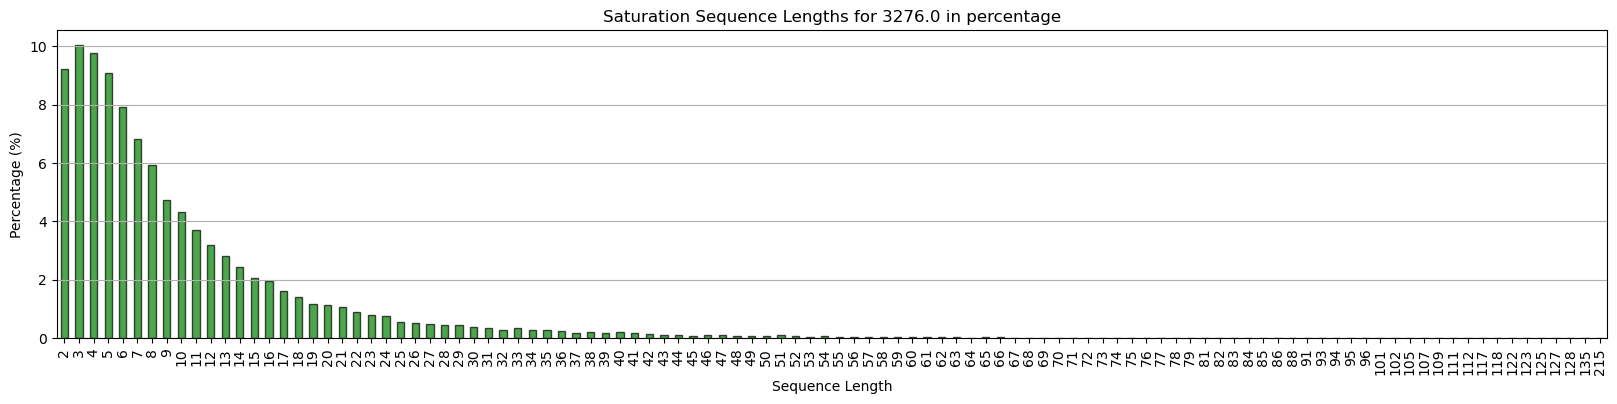

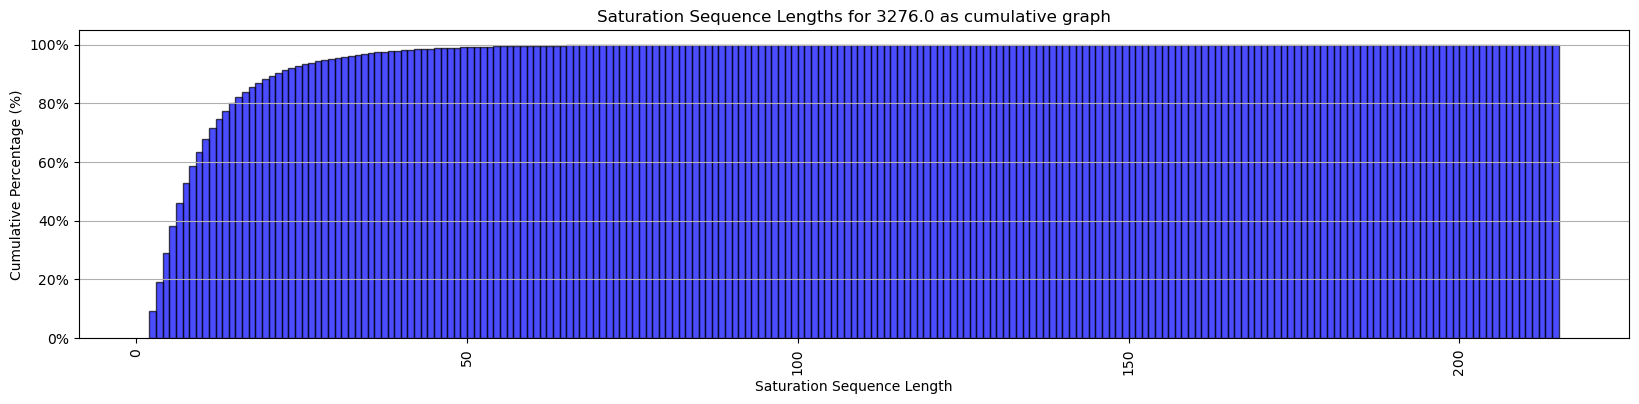

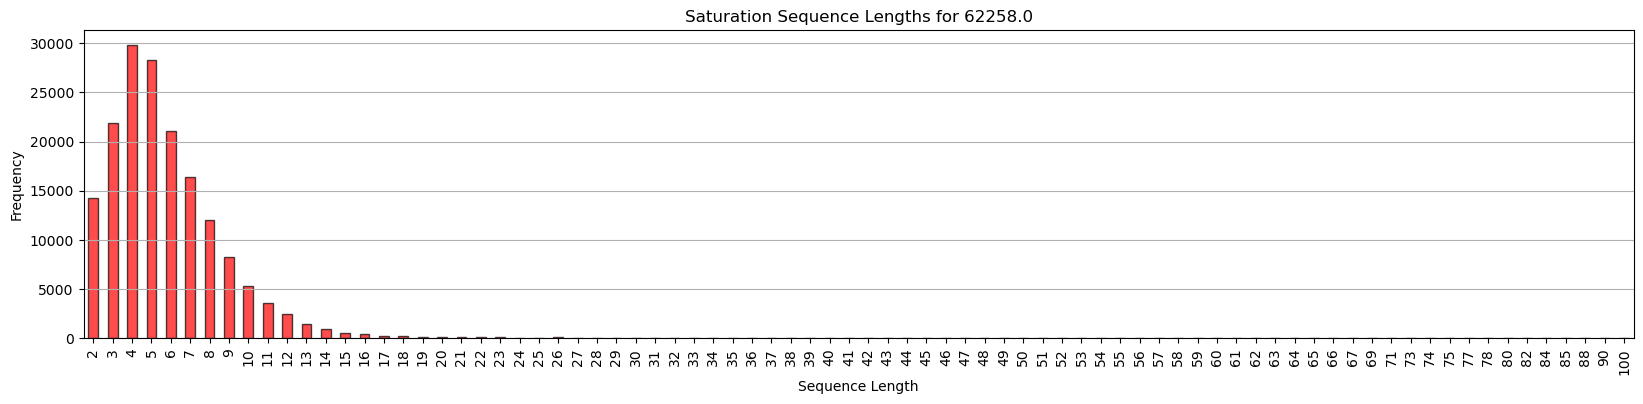

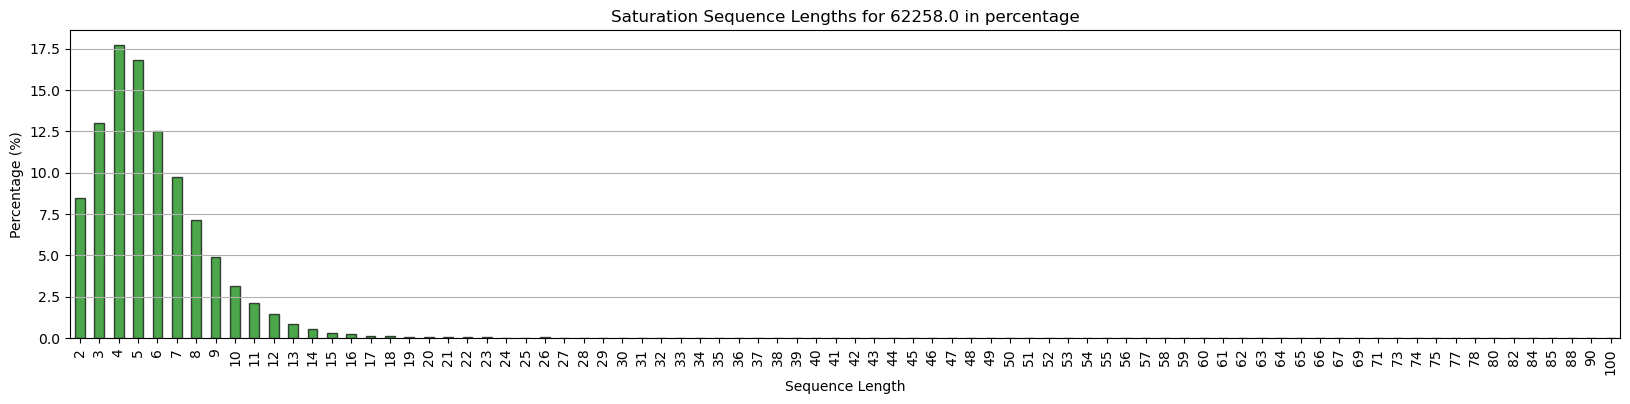

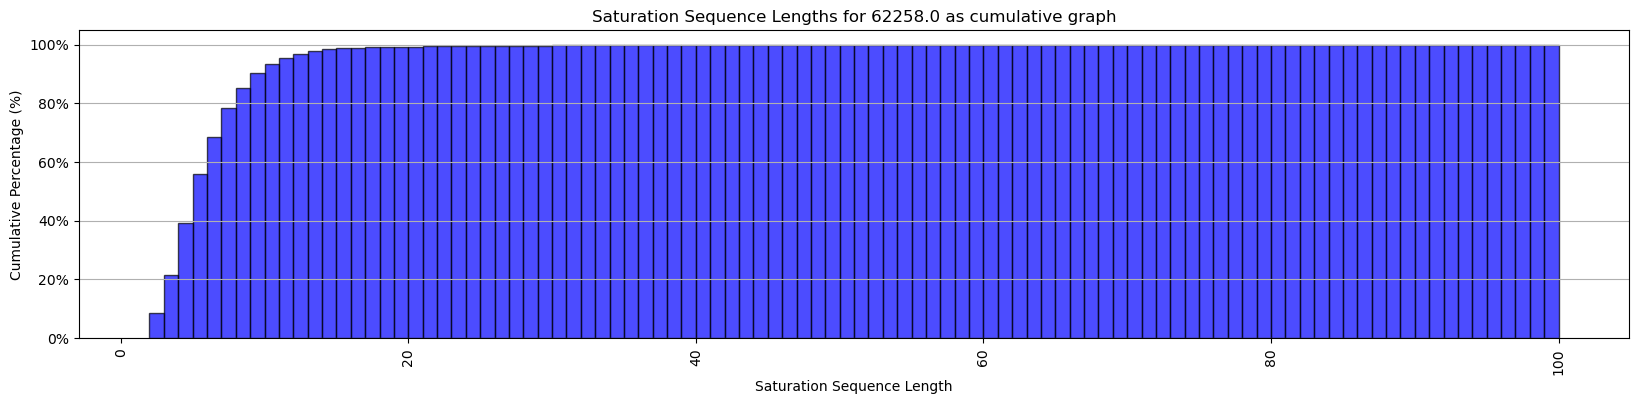

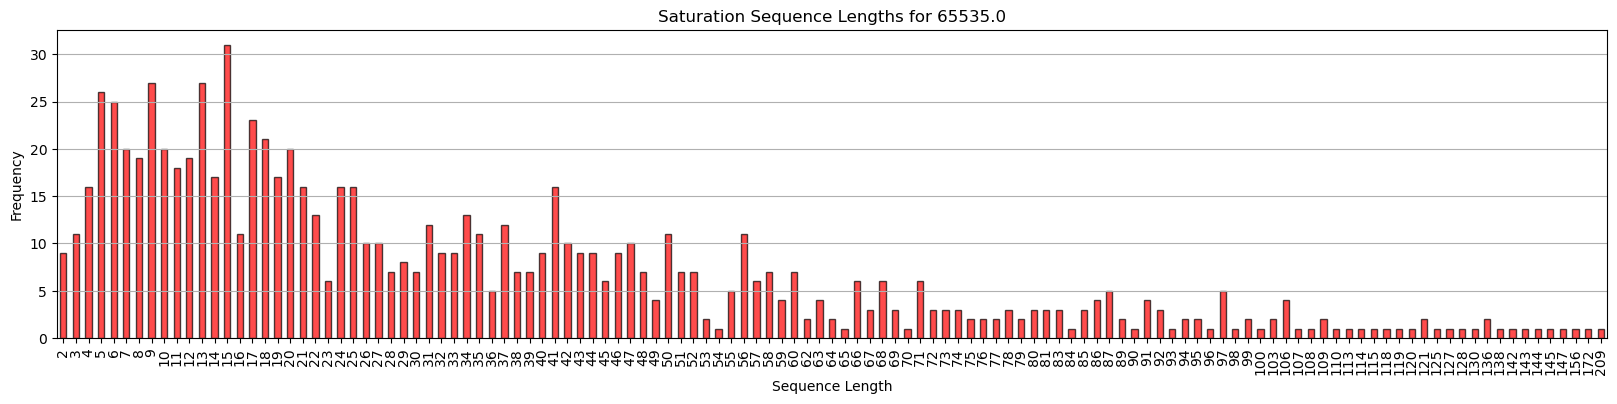

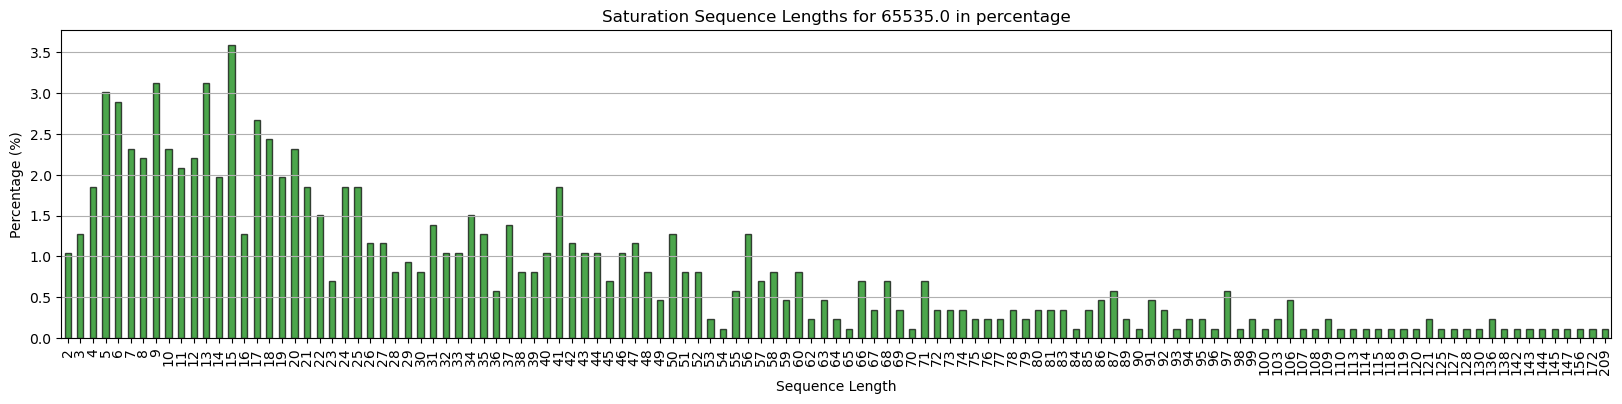

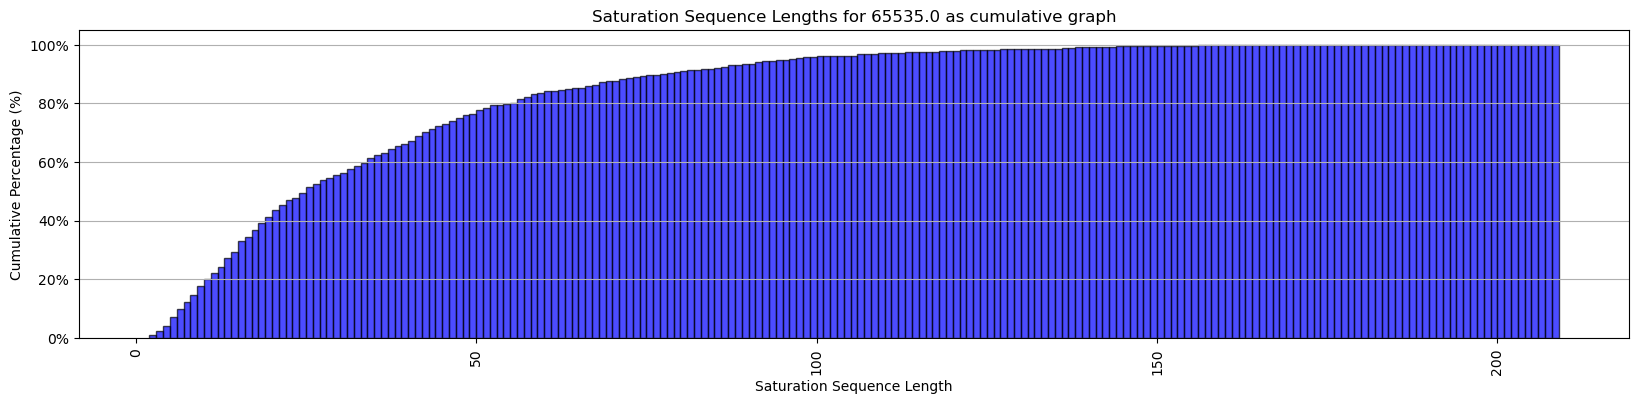

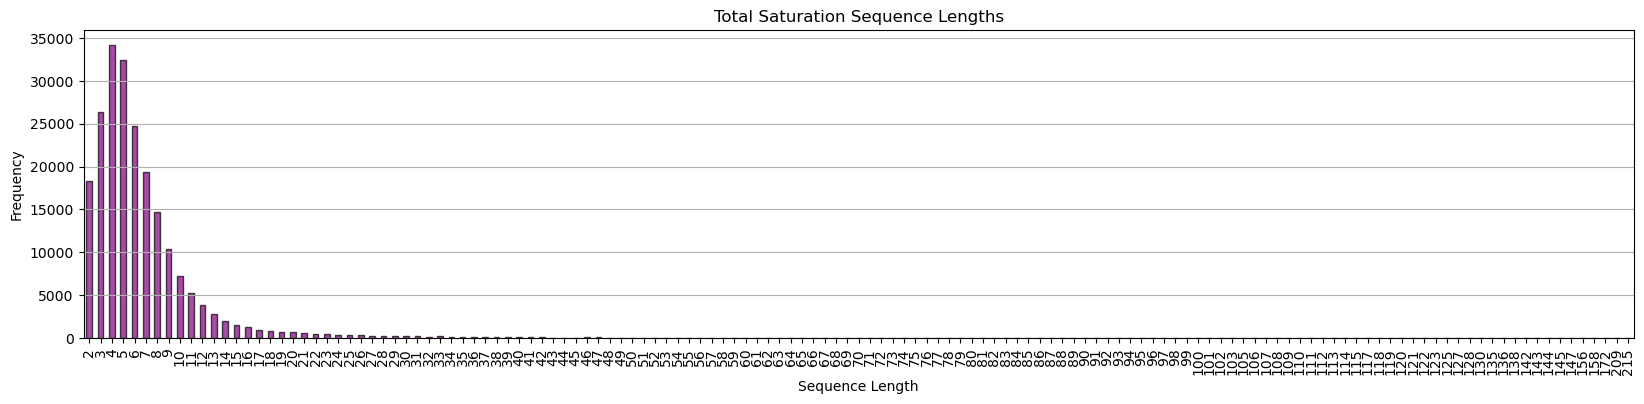

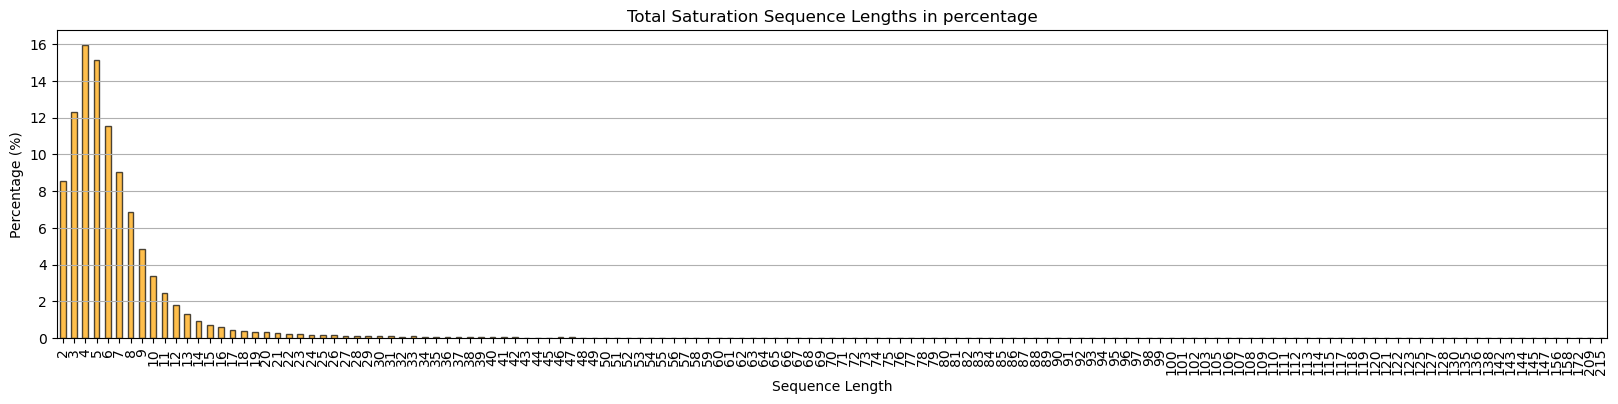

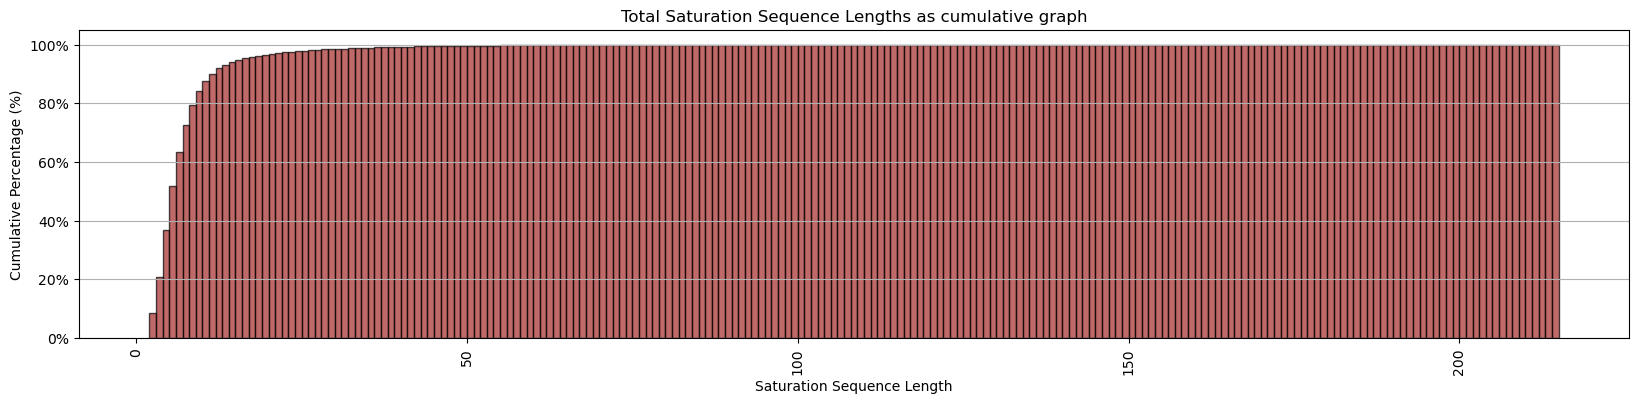

In [14]:
def saturation_workflow(ppg_dataframes, saturation_values, plot_example_count=5):
    """
    Analyzes saturation across multiple PPG datasets and visualizes the sequence lengths
    of saturation events identified by specific PLETH values.

    Parameters:
        ppg_dataframes (list): A list of pandas DataFrame objects, each containing PPG data.
        saturation_values (list): Numeric values within PLETH data that indicate saturation.
        plot_example_count (int): Number of datasets to visually plot for review, default is all.

    Returns:
        list: A list containing detailed records of all saturation events identified.
    """
    # Initialize storage for saturation event sequences and details
    all_sequences_by_value = {value: [] for value in saturation_values}
    all_saturation_details = []

    # Process each DataFrame for saturation analysis
    for i, segment in enumerate(ppg_dataframes):
        signal = segment['PLETH']
        time_stamps = segment['TIMESTAMP_MS']

        # Analyze saturation and collect details
        saturation_dict, saturation_details = analyze_saturation(i, signal, time_stamps, saturation_values)
        all_saturation_details.extend(saturation_details)

        # Collect and aggregate lengths of saturation events for plotting
        for value, sequences in saturation_dict.items():
            sequence_lengths = [length for _, _, length in sequences]
            all_sequences_by_value[value].extend(sequence_lengths)

    # Plot histograms for the saturation sequence lengths
    for value, lengths in all_sequences_by_value.items():
        plot_histogram(lengths, f'Saturation Sequence Lengths for {value}', 'red')
        plot_norm_histogram(lengths, f'Saturation Sequence Lengths for {value} in percentage', 'green')
        plot_cumulative_histogram(lengths, f'Saturation Sequence Lengths for {value} as cumulative graph', 'blue')

    # Combine all sequences for the total distribution plot
    all_combined_lengths = []
    for lengths in all_sequences_by_value.values():
        all_combined_lengths.extend(lengths)
    plot_histogram(all_combined_lengths, 'Total Saturation Sequence Lengths', 'purple')
    plot_norm_histogram(all_combined_lengths, 'Total Saturation Sequence Lengths in percentage', 'orange')
    plot_cumulative_histogram(all_combined_lengths, 'Total Saturation Sequence Lengths as cumulative graph', 'brown')

    return all_saturation_details

def analyze_saturation(segment_index, signal, time_stamps, saturation_values):
    """
    Identifies saturation events within a PPG data segment based on predefined PLETH values.

    Parameters:
        segment_index (int): Index of the data segment within the overall dataset.
        signal (Series): PLETH signal data from a single PPG data segment.
        time_stamps (Series): Timestamps corresponding to each PLETH data point.
        saturation_values (list): Values which indicate saturation within the PLETH data.

    Returns:
        tuple: Contains a dictionary mapping saturation values to event details, and a list of these events.
    """
    # Initialize dictionary to store sequences and details for each saturation value
    saturation_dict = {value: [] for value in saturation_values}
    saturation_details = []

    # Detect saturation events for specified saturation values
    for value in saturation_values:
        # Find indices where the signal matches the saturation value
        indices = np.flatnonzero(signal == value)
        if indices.size > 0:
            # Identify gaps between consecutive indices where the signal is the saturation value
            gaps = np.diff(indices) > 1
            starts = np.r_[indices[0], indices[1:][gaps]]
            ends = np.r_[indices[:-1][gaps], indices[-1]]
            lengths = ends - starts + 1

            # Store the sequence details if the length is greater than or equal to 2
            sequences = [(segment_index, start, length) for start, length in zip(starts, lengths) if length >= 2]
            details = [{
                "segment_number": segment_index,
                "damage_type": "saturation",
                "start_index": start,
                "length": length,
                'start_time_stamp': time_stamps[start],
                "value": value
            } for start, length in zip(starts, lengths) if length >= 2]

            # Append the sequences and details to the respective lists
            saturation_dict[value].extend(sequences)
            saturation_details.extend(details)

    return saturation_dict, saturation_details

def plot_saturation_values(pleth_values, time_stamps, analysis_results, i, saturation_values):
    """
    Visualizes saturation events for a specific PPG segment, highlighting the durations and values of saturation.

    Parameters:
        pleth_values (Series): The PLETH signal values for the segment.
        time_stamps (Series): Timestamps corresponding to the PLETH values.
        analysis_results (dict): Results from the saturation analysis.
        i (int): Index of the current segment in the overall list of dataframes.
        saturation_values (list): List of PLETH values that are considered as saturation.
    """
    # Define a color map for different saturation values
    color_map = {1.0: 'magenta', 3276.0: 'red', 62258.0: 'green', 65535.0: 'blue'}
    plt.figure(figsize=(30, 5))  # Set the figure size
    plt.plot(time_stamps, pleth_values, marker='.', linestyle='-', color='lightblue', label='PLETH Values')

    plotted_labels = set()  # Track which labels have been plotted to avoid duplicates
    for value in saturation_values:
        sequences = analysis_results.get(value, [])
        for _, start_index, length in sequences:
            color = color_map.get(value, 'black')
            label = f'Saturation at {value}' if value not in plotted_labels else ""
            plotted_labels.add(value)
            # Plot the saturation sequences
            plt.plot(time_stamps[start_index:start_index + length], pleth_values[start_index:start_index + length],
                     marker='o', linestyle='-', color=color, linewidth=2, markersize=5, label=label)

    # Set the title and labels for the plot
    plt.title(f'PPG Signal Saturation Analysis No.{i+1}')
    plt.xlabel('Time Stamp (ms)')
    plt.ylabel('PLETH Value')
    plt.legend()
    plt.grid(True)

    # Save the figure to a specified path
    plt.savefig(f'C:/Users/Idan Lichter/OneDrive/Desktop/study/3rd year/Final Project/plots/plot_{i+1}.png')
    plt.close()  # Close the figure after saving to free up memory

def generate_and_save_plots(data):
    """
    Generates and saves plots for each segment of data provided.

    Parameters:
        data (list): List of data segments to be plotted.
    """
    for i, data_segment in enumerate(data):
        plt.figure()  # Create a new figure for each iteration
        plt.plot(data_segment)  # Plot the data segment
        plt.title(f"Plot for segment {i+1}")
        plt.xlabel("X-axis label")
        plt.ylabel("Y-axis label")

        # Save the figure to a specified path
        plt.savefig(f'/path/to/save/directory/plot_{i+1}.png')
        plt.close()  # Close the figure after saving to free up memory

# Execute the saturation workflow with specified saturation values and plot count
all_saturation_events = saturation_workflow(split_ppg_dataframes, [1.0, 3276.0, 62258.0, 65535.0], plot_example_count=5)


**Perfusion Index:**

Value counts of sequence lengths:
2          114
1           69
3           63
4           61
5           40
          ... 
1289         1
1294         1
1313         1
1321         1
4972477      1
Name: count, Length: 987, dtype: int64


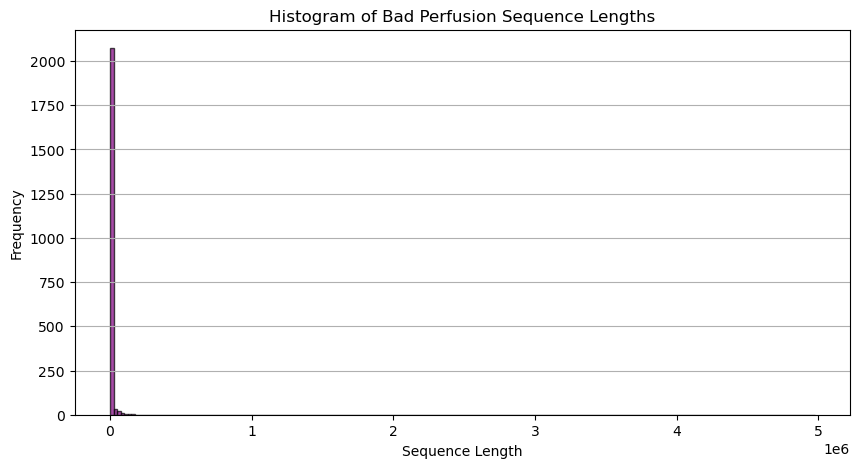

In [15]:
def perfusion_workflow(ppg_dataframes, plot_example_count=5):
    """
    Processes multiple PPG datasets to analyze perfusion quality, specifically focusing on
    identifying sequences where the perfusion index (PI) indicates potential issues.

    Parameters:
        ppg_dataframes (list): List of DataFrame objects, each containing data from a PPG sensor.
        plot_example_count (int): Number of examples for which to plot detailed perfusion analysis.

    Returns:
        list: A list containing detailed information about identified perfusion issues across all datasets.
    """
    all_perfusion_details = []  # Collects details of perfusion events across all dataframes
    all_sequence_lengths = []  # Aggregates lengths of all sequences where perfusion is poor

    for i, segment in enumerate(ppg_dataframes):
        signal = segment['PLETH']
        time_stamps = segment['TIMESTAMP_MS']
        # Identify sequences where perfusion index indicates poor quality
        perfusion_sequences = find_perfusion_sequences(i, segment['PERFUSION_INDEX'], signal)

        # Collect data on the lengths of low perfusion sequences
        sequence_lengths = [length for _, _, length, _ in perfusion_sequences]
        all_sequence_lengths.extend(sequence_lengths)

        # Append detailed perfusion events for later analysis or reporting
        all_perfusion_details.extend([
            {
                "segment_number": segment_index,
                "damage_type": "perfusion_index",
                "start_index": start_index,
                "length": length,
                'start_time_stamp': time_stamps[start_index],
                'value': value
            }
            for segment_index, start_index, length, value in perfusion_sequences])

    # Convert list to numpy array for efficient numerical operations
    all_sequence_lengths = np.array(all_sequence_lengths)

    # Perform value counts to understand the distribution of sequence lengths
    sequence_length_counts = pd.Series(all_sequence_lengths).value_counts().sort_index()

    # Sort the sequence length counts (you can sort either ascending or descending)
    sorted_sequence_length_counts = sequence_length_counts.sort_values(ascending=False)

    # Print the value counts to understand the frequency distribution of sequence lengths
    print("Value counts of sequence lengths:")
    print(sorted_sequence_length_counts)

    # Visualize the distribution of bad perfusion sequence lengths
    plot_perfusion_histogram(all_sequence_lengths, 'Histogram of Bad Perfusion Sequence Lengths', 'purple')

    return all_perfusion_details

def find_perfusion_sequences(segment_index, perfusion_values, signal):
    """
    Identifies sequences where perfusion index is below a critical threshold indicating poor data quality.

    Parameters:
        segment_index (int): Index of the current segment in the dataset.
        perfusion_values (array-like): Array of perfusion index values from the segment.
        signal (array-like): Array of signal values corresponding to the perfusion indices.

    Returns:
        list: A list of tuples describing each identified poor perfusion sequence.
    """
    perfusion_indices = []
    sequences = []
    current_sequence_start = None
    current_sequence_length = 0

    for i, value in enumerate(perfusion_values):
        if value < 1.0:  # Threshold for poor data quality
            if current_sequence_start is None:
                current_sequence_start = i
                current_sequence_start_value = signal[i]
            current_sequence_length += 1
        else:
            if current_sequence_length > 0:
                # Append the sequence details if it qualifies as a poor perfusion area
                sequences.append((segment_index, current_sequence_start, current_sequence_length, current_sequence_start_value))
                current_sequence_start = None
                current_sequence_length = 0
    if current_sequence_length > 0:
        sequences.append((segment_index, current_sequence_start, current_sequence_length, current_sequence_start_value))

    return sequences

def plot_perfusion_values(pleth_values, time_stamps, perfusion_sequences, i):
    """
    Plots the PLETH values of a segment highlighting areas with poor perfusion.

    Parameters:
        pleth_values (array-like): Array of PLETH values in the segment.
        time_stamps (array-like): Array of timestamps corresponding to the PLETH values.
        perfusion_sequences (list): List of identified poor perfusion sequences within the segment.
        i (int): Index of the current segment being plotted.
    """
    plt.figure(figsize=(30, 5))  # Set the figure size for better visualization
    plt.plot(time_stamps, pleth_values, marker='.', linestyle='-', color='lightblue', label='PLETH Values')

    for _, start_index, length in perfusion_sequences:
        # Highlight the poor perfusion areas in red
        plt.plot(time_stamps[start_index:start_index + length], pleth_values[start_index:start_index + length], 'r.', label='Bad Perfusion Area' if start_index == perfusion_sequences[0][1] else "")

    plt.title(f'PPG Signal Bad Perfusion Analysis No.{i}')
    plt.xlabel('Time Stamp (ms)')
    plt.ylabel('PLETH Value')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_perfusion_histogram(sequence_lengths, title, color):
    """
    Plots a histogram of sequence lengths where perfusion index indicated poor quality.

    Parameters:
        sequence_lengths (array-like): Array of sequence lengths to plot.
        title (str): Title of the histogram.
        color (str): Color of the histogram bars.
    """
    plt.figure(figsize=(10, 5))  # Set the figure size
    plt.hist(sequence_lengths, bins=200, color=color, alpha=0.7, edgecolor='black')  # Plot the histogram
    plt.title(title)  # Set the title of the plot
    plt.xlabel('Sequence Length')  # Label the x-axis
    plt.ylabel('Frequency')  # Label the y-axis
    plt.grid(axis='y')  # Add gridlines to the y-axis for better readability
    plt.show()

# Execute the workflow and visualize the results
all_perfusion_events = perfusion_workflow(split_ppg_dataframes, plot_example_count=5)

**Repeating Values**:

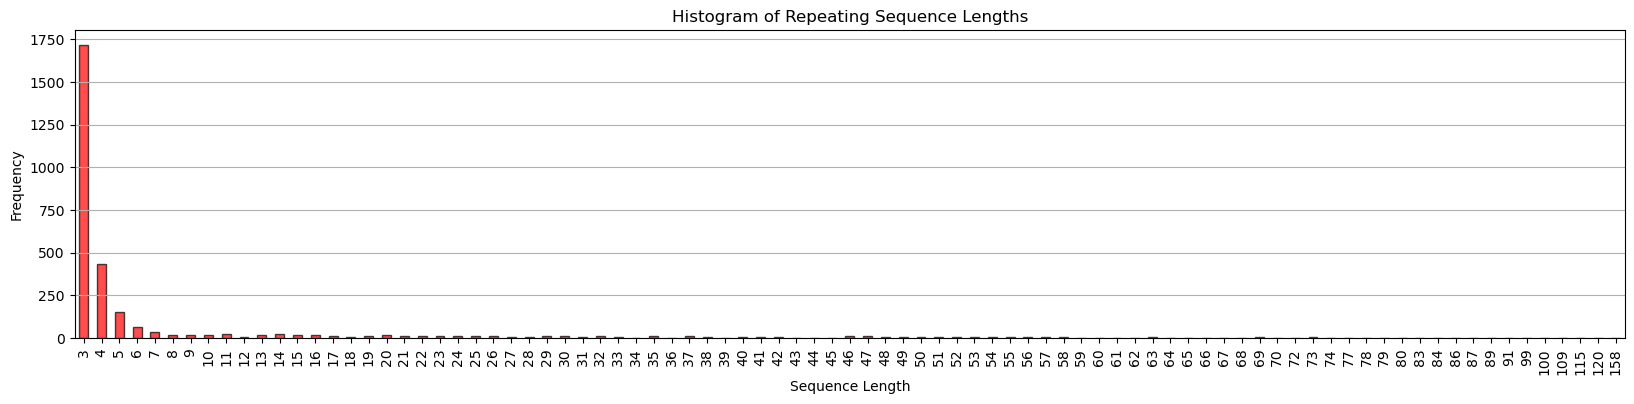

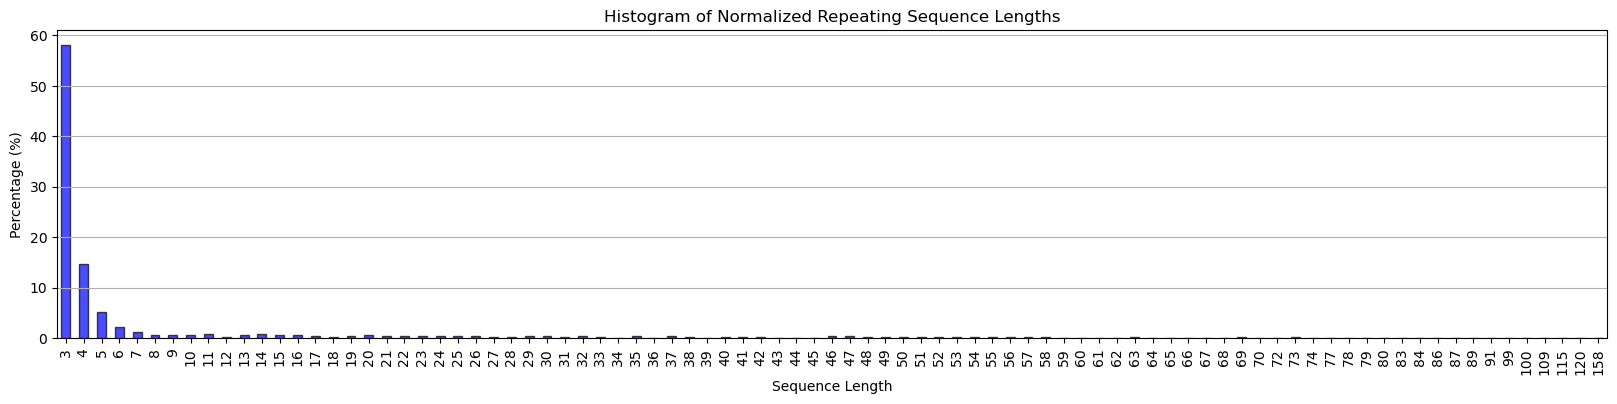

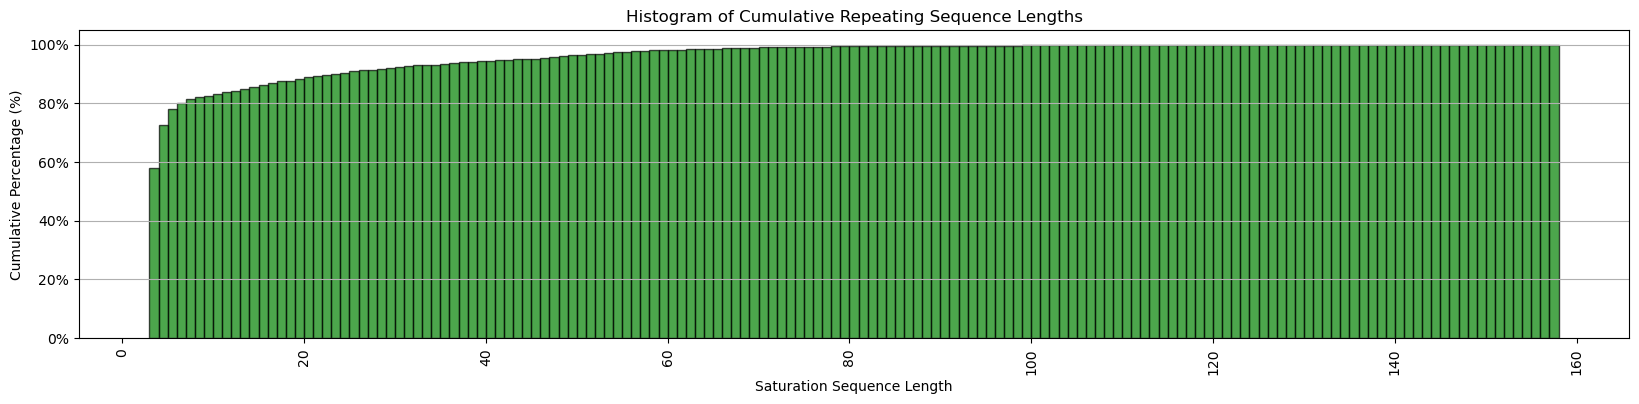

In [16]:
def repeating_sequences_workflow(ppg_dataframes, exclusion_values, plot_example_count=5):
    """
    Analyzes repeating value sequences across multiple PPG datasets and visualizes these repetitions.

    Parameters:
        ppg_dataframes (list): List of DataFrame objects, each containing data from a PPG sensor.
        exclusion_values (list): Values to exclude from analysis, considered as non-relevant for repeating detection.
        plot_example_count (int): Number of datasets to plot for detailed analysis.

    Returns:
        list: A list of dictionaries detailing the found repeating sequences.
    """
    all_repeating_details = []  # Accumulates all repeating sequence details

    for i, df in enumerate(ppg_dataframes):
        signal = df['PLETH'].values
        time_stamps = df['TIMESTAMP_MS'].values
        sequence_details = find_repeating_sequences(i, signal, exclusion_values)

        # Collect data on the sequences of repeating values
        all_repeating_details.extend([
            {
                "segment_number": seg_index,
                "damage_type": "repeating_values",
                "start_index": start_index,
                "length": length,
                'start_time_stamp': time_stamps[start_index],
                'value': value
            }
            for seg_index, start_index, length, value in sequence_details
        ])

        # Optionally plot repeating sequences for a subset of data frames
        # if i < plot_example_count:
        #     plot_repeating_indices(signal, time_stamps, sequence_details)

    # Gather all sequence lengths for histogram plotting
    all_repeating_lengths = [d['length'] for d in all_repeating_details]

    # Plot histograms to visualize the distribution of repeating sequence lengths
    plot_histogram(all_repeating_lengths, 'Histogram of Repeating Sequence Lengths', 'red')
    plot_norm_histogram(all_repeating_lengths, 'Histogram of Normalized Repeating Sequence Lengths', 'blue')
    plot_cumulative_histogram(all_repeating_lengths, 'Histogram of Cumulative Repeating Sequence Lengths', 'green')
    return all_repeating_details

def find_repeating_sequences(segment_index, signal, exclusion_values):
    """
    Identifies sequences of repeating values in a PPG signal, excluding specified values.

    Parameters:
        segment_index (int): Index of the data segment within the overall dataset.
        signal (array-like): PLETH signal data from a single PPG data segment.
        exclusion_values (list): Values which should be ignored as they do not indicate true repeating sequences.

    Returns:
        list: A list of tuples describing each identified repeating sequence.
    """
    sequences = []  # Store found sequences here
    current_value = None  # Track the current value being repeated
    sequence_start = 0  # Start index of current sequence
    sequence_length = 0  # Length of current sequence

    for i in range(1, len(signal) - 1):  # Iterate with ability to look ahead and behind
        if signal[i] not in exclusion_values:
            if signal[i] == current_value or current_value is None:
                if current_value is None:
                    sequence_start = i
                current_value = signal[i]
                sequence_length += 1
            else:
                if sequence_length >= 3:
                    sequences.append((segment_index, sequence_start, sequence_length, current_value))
                current_value = signal[i]
                sequence_length = 1
        else:
            if sequence_length >= 3:
                sequences.append((segment_index, sequence_start, sequence_length, current_value))
            current_value = None
            sequence_length = 0

    # Check if the last sequence qualifies to be added
    if sequence_length >= 3:
        sequences.append((segment_index, sequence_start, sequence_length, current_value))

    return sequences

def plot_repeating_indices(pleth_values, time_stamps, sequence_details):
    """
    Visualizes repeating sequences in a PPG signal, highlighting the specific repetitions.

    Parameters:
        pleth_values (array-like): The PLETH signal values.
        time_stamps (array-like): Timestamps corresponding to the PLETH values.
        sequence_details (list): Details of the repeating sequences to be visualized.
    """
    plt.figure(figsize=(20, 5))
    plt.plot(time_stamps, pleth_values, marker='.', linestyle='-', color='lightblue', label='PLETH Values')

    color_map = {'max_point': 'magenta', 'min_point': 'green', 'upward trend': 'red', 'downward trend': 'blue'}

    used_labels = set()  # To prevent label duplication in legend
    for _, start_index, length, location in sequence_details:
        end_index = start_index + length
        color = color_map.get(location, 'black')  # Default to black if not specified
        label = f'{location}' if location not in used_labels else ""
        plt.plot(time_stamps[start_index:end_index], pleth_values[start_index:end_index],
                 'x', color=color, label=label)
        if label:  # Add new label to set
            used_labels.add(location)

    plt.title('PPG Signal Repetition Values Analysis')
    plt.xlabel('Time Stamp (ms)')
    plt.ylabel('PLETH Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution to process and visualize repeating sequences in PPG data
all_repeating_values_events = repeating_sequences_workflow(split_ppg_dataframes, [0, 3276.0, 62258.0, 65535.0], plot_example_count=5)

**Identifying and marking Gaps in time:**

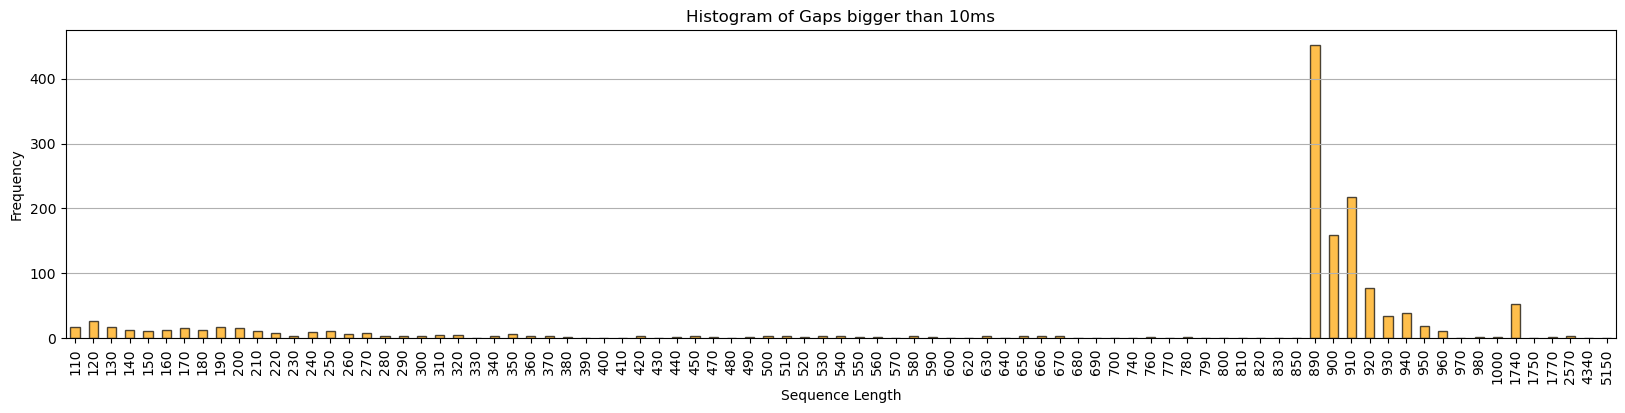

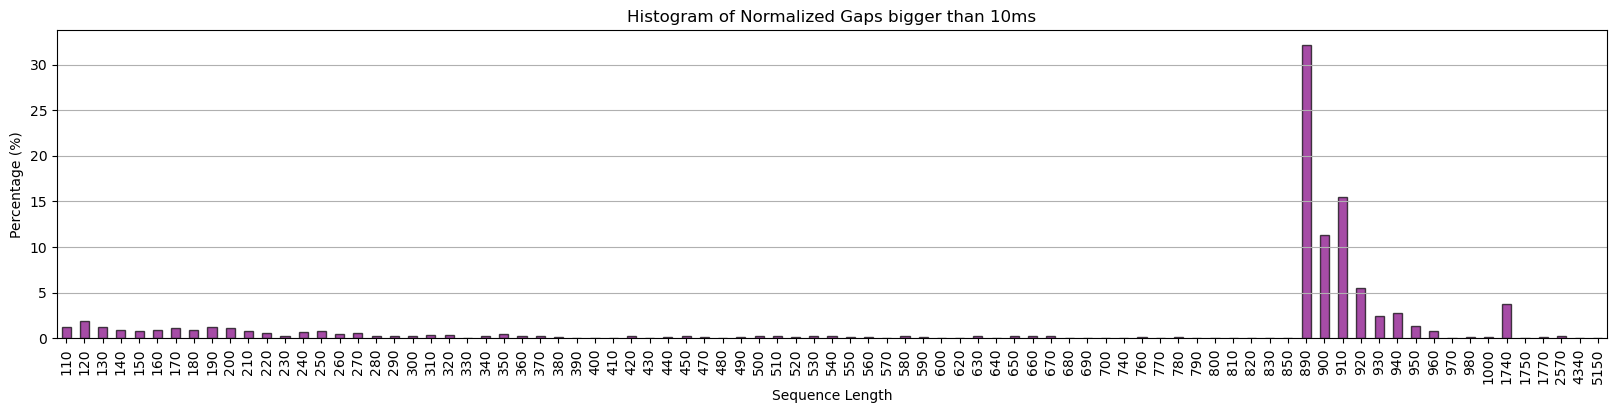

In [17]:
def gaps_workflow(dataframes, threshold=10, plot_example_count=5):
    """
    Analyzes time gaps within PPG datasets that exceed a specified threshold, collecting details about these gaps.

    Parameters:
        dataframes (list): A list of pandas DataFrame objects each containing PPG sensor data.
        threshold (int): The minimum size of time gap (in ms) to consider significant.
        plot_example_count (int): Number of segments to visually plot for gap analysis.

    Returns:
        list: A list of dictionaries detailing the gaps found in each segment.
    """
    all_gap_details = []  # Store details of all identified gaps

    for i, segment in enumerate(dataframes):
        time_stamps = segment['TIMESTAMP_MS'].values
        pleth_values = segment['PLETH'].values
        gap_indices = find_large_gaps(i, pleth_values, time_stamps, threshold)  # Identify gaps that exceed threshold

        # Collect detailed information about each identified gap
        for seg_index, start_index, end_index, value in gap_indices:
            gap_size = time_stamps[end_index] - time_stamps[start_index]
            start_time_stamp = time_stamps[start_index]

            all_gap_details.append({
                "segment_number": seg_index,
                "damage_type": "gaps",
                "start_index": start_index,
                "length": end_index - start_index,
                "gap_size": gap_size,
                'start_time_stamp': time_stamps[start_index],
                'value': value
            })

    # Generate histograms for visualizing gap sizes
    gap_sizes = [gap['gap_size'] for gap in all_gap_details]
    plot_histogram(gap_sizes, 'Histogram of Gaps bigger than 10ms', 'orange')
    plot_norm_histogram(gap_sizes, 'Histogram of Normalized Gaps bigger than 10ms', 'purple')
    return all_gap_details

def find_large_gaps(segment_index, pleth_values, time_stamps, threshold=10):
    """
    Identifies gaps in time stamps that exceed a specified threshold within a PPG data segment.

    Parameters:
        segment_index (int): Index of the current data segment.
        pleth_values (array-like): Array of PLETH values corresponding to time stamps.
        time_stamps (array-like): Array of time stamps for the data segment.
        threshold (int): Gap size threshold for identifying significant gaps.

    Returns:
        list: A list of tuples describing the index and size of each identified gap.
    """
    gap_indices = []
    for i in range(1, len(time_stamps)):
        gap_size = time_stamps[i] - time_stamps[i-1]
        if gap_size > threshold:
            gap_indices.append((segment_index, i-1, i, pleth_values[i]))  # Record gaps exceeding threshold

    return gap_indices

def plot_with_gaps(segment_index, pleth_values, time_stamps, gap_indices):
    """
    Visualizes identified gaps in a PPG signal.

    Parameters:
        segment_index (int): Index of the segment being plotted.
        pleth_values (array-like): The PLETH signal values.
        time_stamps (array-like): Corresponding timestamps for the PLETH values.
        gap_indices (list): List of gap details including start and end indices.
    """
    plt.figure(figsize=(30, 5))
    plt.plot(time_stamps, pleth_values, marker='.', linestyle='-', color='lightblue', label='PLETH Values')

    # Visual markers for gaps
    color_map = {'max_point': 'magenta', 'min_point': 'green', 'upward trend': 'red', 'downward trend': 'cyan', 'undefined': 'gray'}
    used_labels = set()

    for _, start, end, location in gap_indices:
        start_color = 'red'  # Highlight the start of a gap
        end_color = 'green'  # Highlight the end of a gap
        plt.plot(time_stamps[start], pleth_values[start], 'o', color=start_color, markersize=10, label='Start of Gap' if 'Start of Gap' not in used_labels else "")
        plt.plot(time_stamps[end], pleth_values[end], 'o', color=end_color, markersize=10, label='End of Gap' if 'End of Gap' not in used_labels else "")
        used_labels.update(['Start of Gap', 'End of Gap'])

    plt.title(f'PPG segment No.{segment_index} with Gaps Highlighted')
    plt.xlabel('Time Stamp (ms)')
    plt.ylabel('PLETH Value')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution to process and visualize repeating sequences in PPG data
all_gap_events = gaps_workflow(split_ppg_dataframes, threshold=10, plot_example_count=5)

**Create Damage Sequences dfs:**

We conducted an in-depth analysis of the integrity of PPG signal data across four primary types of anomalies: saturation values , PI values, repeating values, and timestamp gaps. By examining these damage types in a unified and broader context, we aim to identify the most prevalent sources of data degradation, understand their impact on signal quality, and develop strategies to mitigate these issues, thereby enhancing the overall reliability and usability of the PPG data for further analysis.


In [18]:
#create a df for each type of damage:
saturation_events_df = pd.DataFrame(all_saturation_events)
perfusion_events_df = pd.DataFrame(all_perfusion_events)
repeating_values_events_df = pd.DataFrame(all_repeating_values_events)
gap_events_df = pd.DataFrame(all_gap_events)

# Combining all dfs into a single damage df:
damage_events_df = pd.concat([saturation_events_df , perfusion_events_df , repeating_values_events_df , gap_events_df])

# Calculate 'end_index' and create a new column
end_index = damage_events_df['start_index'] + damage_events_df['length']

# Insert 'end_index' into the DataFrame after 'start_index'
damage_events_df.insert(3, 'end_index', end_index)

In [19]:
damage_events_df.head(50)

,segment_number,damage_type,start_index,end_index,length,start_time_stamp,value,gap_size
0,0,saturation,77193,77204,11,783970,1.0,NaN
1,0,saturation,77946,77984,38,791500,1.0,NaN
2,0,saturation,78010,78022,12,792140,1.0,NaN
3,0,saturation,78032,78053,21,792360,1.0,NaN
4,0,saturation,122968,122978,10,1251690,1.0,NaN
5,0,saturation,123124,123170,46,1253250,1.0,NaN
6,0,saturation,123192,123229,37,1253930,1.0,NaN
7,0,saturation,123434,123444,10,1256350,1.0,NaN
8,0,saturation,123671,123677,6,1258720,1.0,NaN
9,0,saturation,123966,123974,8,1261670,1.0,NaN


In [20]:
damage_events_df['damage_type'].value_counts()

damage_type
saturation          214110
repeating_values      2955
perfusion_index       2159
gaps                  1405
Name: count, dtype: int64

**Prcentage of each damage areas in order to understand what is most common issue in PPG data:**

In [21]:
total = len(damage_events_df)
saturation_precen = (214110 / total)*100
repeating_values_precen = (2955 / total)*100
perfusion_index_precen = (2156 / total)*100
gaps_precen = (1405 / total)*100

print('saturation_precen:',saturation_precen,'%')
print('repeating_values_precen:',repeating_values_precen,'%')
print('perfusion_index_precen:',perfusion_index_precen,'%')
print('gaps_precen:',gaps_precen,'%')

saturation_precen: 97.04526603483676 %
repeating_values_precen: 1.3393524876602805 %
perfusion_index_precen: 0.9772060789832705 %
gaps_precen: 0.63681564980125 %


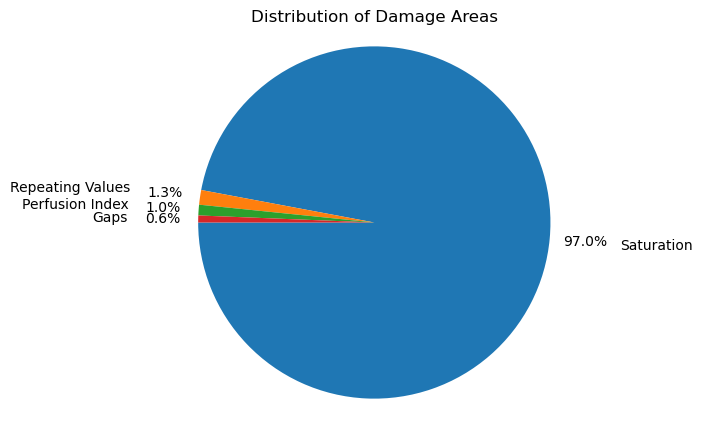

In [22]:
# Labels for the pie chart
labels = ['Saturation', 'Repeating Values', 'Perfusion Index', 'Gaps']

# Values for the pie chart
sizes = [saturation_precen, repeating_values_precen, perfusion_index_precen, gaps_precen]

# Create a pie chart
plt.figure(figsize=(5, 5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=180, pctdistance=1.2, labeldistance=1.4)
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.

# Display the plot
plt.title('Distribution of Damage Areas')
plt.show()

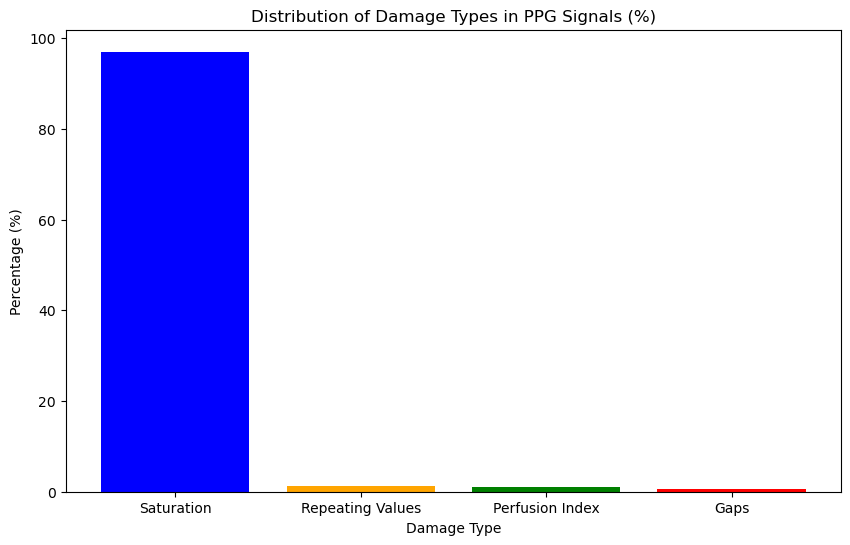

In [23]:
# Data for the bar plot
labels = ['Saturation', 'Repeating Values', 'Perfusion Index', 'Gaps']
percentages = [saturation_precen, repeating_values_precen, perfusion_index_precen, gaps_precen]

# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, percentages, color=['blue', 'orange', 'green', 'red'])

# Adding titles and labels
plt.title('Distribution of Damage Types in PPG Signals (%)')
plt.xlabel('Damage Type')
plt.ylabel('Percentage (%)')

# Display the plot
plt.show()


**From pie chart and bar plot we can understand that Sturation values are the most common damaged area type in PPG siganls. Thus, it needs to be handled in our project.**

In [24]:
# Dataframe contains all relevant data regarding saturations in our PPG data
saturation_events_df

# Check the distribution of saturation values
saturation_value_counts = saturation_events_df['value'].value_counts()

# Display the DataFrame
display(saturation_events_df)

# Display the distribution of saturation values
print(saturation_value_counts)

,segment_number,damage_type,start_index,length,start_time_stamp,value
0,0,saturation,77193,11,783970,1.0
1,0,saturation,77946,38,791500,1.0
2,0,saturation,78010,12,792140,1.0
3,0,saturation,78032,21,792360,1.0
4,0,saturation,122968,10,1251690,1.0
...,...,...,...,...,...,...
214105,57,saturation,21598,33,223900,65535.0
214106,57,saturation,21667,4,224590,65535.0
214107,57,saturation,21711,14,225030,65535.0
214108,57,saturation,21856,26,226480,65535.0


value
62258.0    168344
3276.0      44292
65535.0       863
1.0           611
Name: count, dtype: int64


In [25]:
# Check the distribution of saturation values regarding each saturated value
total_satu = len(saturation_events_df)
satu_65535 = (863/total_satu)*100
satu_62258 = (168344/total_satu)*100
satu_3276 = (44292/total_satu)*100
satu_1 = (611/total_satu)*100

# Precentage of each saturated value
print('satu_65535:',satu_65535,'%')
print('satu_62258:',satu_62258,'%')
print('satu_3276:',satu_3276,'%')
print('satu_1:',satu_1,'%')

satu_65535: 0.4030638456867965 %
satu_62258: 78.62500583812059 %
satu_3276: 20.686562981644947 %
satu_1: 0.2853673345476624 %


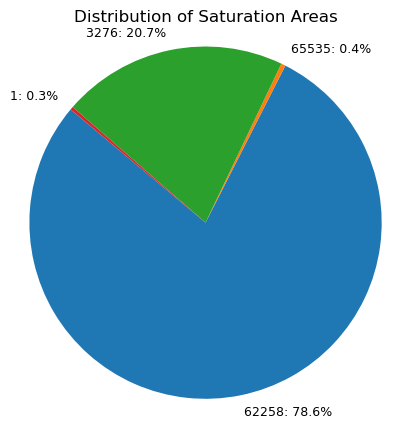

In [26]:
# Labels for the pie chart
satu_labels = ['62258','65535', '3276', '1']

# Values for the pie chart
satu_sizes = [satu_62258, satu_65535, satu_3276, satu_1]

# Create a pie chart with smaller font size for the labels
plt.figure(figsize=(5, 5))
plt.pie(satu_sizes, labels=[f'{label}: {size:.1f}%' for label, size in zip(satu_labels, satu_sizes)],
        startangle=140, textprops={'fontsize': 9})
plt.axis('equal')  # Equal aspect ratio ensures the pie is drawn as a circle.

# Display the plot
plt.title('Distribution of Saturation Areas')
plt.show()


**To ensure the continuity of the PPG data, we implemented a gap-filling process aimed at addressing missing timestamps. This process involved identifying intervals where the data was either missing or not recorded, creating gaps in the timestamps. The method systematically detected these gaps and inserted empty rows into the corresponding dataframes to simulate the missing data points. These inserted rows contain null values for all measurements, except for the timestamp, which is appropriately incremented to bridge the gap. By maintaining a continuous time series, this approach enhances the quality of the data, which is crucial for accurate time-series analysis, particularly in the next step of predicting blood pressure from PPG signals.**

In [27]:
def add_rows_between_gaps(ppg_dataframes, gap_events_df, tolerance=5):
    """
    Adds empty rows into PPG dataframes based on the identified gaps in the data to simulate missing data points.

    This function handles gaps where the time interval exceeds 10ms by inserting rows with
    null values for all measurements except the timestamp, which is incremented appropriately.

    Parameters:
        ppg_dataframes (list of pd.DataFrame): A list of dataframes, each representing a segment of PPG data.
        gap_events_df (pd.DataFrame): A dataframe containing records of gaps including their sizes and timestamps.
        tolerance (int): The range (in ms) within which a timestamp can be considered a match for the gap start time.

    """
    for i, gap in gap_events_df.iterrows():
        segment_number = gap['segment_number']
        start_timestamp = gap['start_time_stamp']
        gap_size = gap['gap_size']
        rows_to_add = (gap_size - 10) // 10  # Calculate number of rows to add based on the gap size

        df = ppg_dataframes[segment_number]  # Access the specific DataFrame based on segment_number

        # Convert TIMESTAMP_MS to int64 for consistent comparison and manipulation
        df['TIMESTAMP_MS'] = df['TIMESTAMP_MS'].astype(np.int64)
        start_timestamp = int(start_timestamp)

        # Find the index where the new rows should be inserted within a given tolerance
        match_indices = df.index[(df['TIMESTAMP_MS'] >= start_timestamp - tolerance) &
                                 (df['TIMESTAMP_MS'] <= start_timestamp + tolerance)]

        if match_indices.empty:
            print(f"Warning: No matching timestamp found for {start_timestamp} in segment {segment_number}")
            continue

        start_index = match_indices[0]
        patient_id = df.at[start_index, 'ID']

        # Generate new timestamps for the empty rows to be inserted
        timestamps = [start_timestamp + (i + 1) * 10 for i in range(rows_to_add)]

        # Prepare dictionaries for new rows with null values except for the timestamp
        empty_row_dicts = [
            {
                'ID': patient_id,
                'DataTime': None,
                'TIMESTAMP_MS': ts,
                'COUNTER': None,
                'PULSE_BPM': None,
                'SPO2_PCT': None,
                'SPO2_STATUS': None,
                'PLETH': None,
                'BATTERY_PCT': None,
                'RED_ADC': None,
                'IR_ADC': None,
                'PERFUSION_INDEX': None
            }
            for ts in timestamps
        ]

        # Create a DataFrame from the list of dictionaries for new rows
        empty_rows = pd.DataFrame(empty_row_dicts)

        # Insert the new rows into the dataframe at the correct position
        ppg_dataframes[segment_number] = pd.concat(
            [df.iloc[:start_index + 1], empty_rows, df.iloc[start_index + 1:]]
        ).reset_index(drop=True)

# na_ppg_dataframes is same as the original list split_ppg_dataframes, with additional rows inserted to ensure that the time series is continuous
nan_ppg_dataframes = [df.copy() for df in split_ppg_dataframes]
add_rows_between_gaps(nan_ppg_dataframes, gap_events_df)


In [28]:
nan_ppg_dataframes[0]

,ID,DataTime,TIMESTAMP_MS,COUNTER,PULSE_BPM,SPO2_PCT,SPO2_STATUS,PLETH,BATTERY_PCT,RED_ADC,IR_ADC,PERFUSION_INDEX
0,22054597,2021-05-26 18:50:34.924,0,9.0,68.0,100.0,0.0,22209.0,64.6,129690.0,172571.0,4.3
1,22054597,2021-05-26 18:50:34.934,10,10.0,68.0,100.0,0.0,22069.0,64.6,129713.0,172149.0,4.3
2,22054597,2021-05-26 18:50:34.944,20,11.0,68.0,100.0,0.0,21928.0,64.6,129715.0,172214.0,4.3
3,22054597,2021-05-26 18:50:34.954,30,12.0,68.0,100.0,0.0,21783.0,64.6,129920.0,172362.0,4.3
4,22054597,2021-05-26 18:50:34.964,40,13.0,68.0,100.0,0.0,21642.0,64.6,129897.0,172478.0,4.3
...,...,...,...,...,...,...,...,...,...,...,...,...
1887624,22054597,2021-05-27 00:05:11.164,18876240,1887633.0,255.0,12.7,2.0,0.0,35.3,143511.0,243897.0,0.0
1887625,22054597,2021-05-27 00:05:11.174,18876250,1887634.0,255.0,12.7,2.0,0.0,35.3,143527.0,243903.0,0.0
1887626,22054597,2021-05-27 00:05:11.184,18876260,1887635.0,255.0,12.7,2.0,0.0,35.3,143502.0,243854.0,0.0
1887627,22054597,2021-05-27 00:05:11.194,18876270,1887636.0,255.0,12.7,2.0,0.0,35.3,143530.0,243900.0,0.0


**The function modify_damaged_ppg_rows starts by filtering out rows in the damage_events_df DataFrame that are related to 'gaps'. This is because 'gaps' have already been handled separately through gap-filling, and the focus here is on other types of damage, such as saturation, perfusion index issues, and repeating values replace index of damaged area into None.The main goal is to address and handle damaged PPG data points by modifying the original data. This process is crucial for improving the quality and reliability of the dataset, especially as we prepare it for further analysis, such as blood pressure prediction from PPG signals.**

In [29]:
def modify_damaged_ppg_rows(ppg_dataframes, damage_events_df):
    """
    Modifies the PLETH values in PPG datasets by setting them to NaN for timestamps that correspond to
    certain types of damage, including specific saturation and repeating value issues, and also for low PI.

    The function ensures that damaged data points, identified by specific timestamps and
    marked by damage types other than 'gaps', are nullified to prevent their use in further
    analysis or processing.

    Parameters:
        ppg_dataframes (list of pandas.DataFrame): A list of dataframes, each representing a segment of PPG data.
        damage_events_df (pandas.DataFrame): A dataframe containing details of damaged data points
        including the segment number, type of damage, and the exact timestamp of the damage.

    Process:
        1. Filters out 'gaps' type damages from the damage events dataframe to prevent exclusion from analysis.
        2. Builds a dictionary mapping segment numbers to lists of timestamps where damage (other than gaps) occurred.
        3. Iterates over each segment's dataframe in the provided list of PPG dataframes.
        4. For each segment, checks if it has any associated damaged timestamps and modifies the 'PLETH' column values at these timestamps to None.
        5. Additionally, for each segment, checks the 'PERFUSION_INDEX' and sets 'PLETH' to NaN where 'PERFUSION_INDEX' is less than 1.
    """
    # Filter out damage events related to 'gaps' as they are not considered for modification
    filtered_damage_events_df = damage_events_df[damage_events_df['damage_type'] != 'gaps']

    # Create a dictionary to map each segment to its respective damaged timestamps and lengths
    damage_dict = {}

    for index, row in filtered_damage_events_df.iterrows():
        segment = row['segment_number']
        timestamp = row['start_time_stamp']
        length = row['length']  # Assuming there is a 'length' column in the dataframe
        if segment in damage_dict:
            damage_dict[segment].append((timestamp, length))
        else:
            damage_dict[segment] = [(timestamp, length)]

    # Modify PLETH values in each dataframe based on the damage dictionary
    for segment_number, df in enumerate(ppg_dataframes):
        if segment_number in damage_dict:
            for timestamp, length in damage_dict[segment_number]:
                start_index = df.index[df['TIMESTAMP_MS'] == timestamp].tolist()[0]
                end_index = start_index + length
                # Nullify the PLETH values for the specified length starting from the timestamp
                df.loc[start_index:end_index+1, 'PLETH'] = None

        # Additionally, modify PLETH values based on perfusion index
        if 'PERFUSION_INDEX' in df.columns:
            # Update 'PLETH' values to NaN where 'PERFUSION_INDEX' is less than 1
            df.loc[df['PERFUSION_INDEX'] < 1, 'PLETH'] = np.nan


modify_damaged_ppg_rows(nan_ppg_dataframes, damage_events_df)

In [30]:
# Define the directory path where you want to save the files
directory_path = 'C:/Users/adior/Documents/Digital Medical Tech - degree/Final Mop Project/Train Files/Train files with Nan'
#directory_path = 'C:/Users/Idan Lichter/OneDrive/Desktop/study/3rd year/Final Project/Train Files with NaN'

# Create the directory if it does not exist
os.makedirs(directory_path, exist_ok=True)

for i, df in enumerate(nan_ppg_dataframes):
    file_path = os.path.join(directory_path, f'df Num.{i}.csv')
    df.to_csv(file_path, index=False)  # Save each dataframe to a CSV file with the patient ID in the filename